In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
from pandarallel import pandarallel

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
ab = '../../lr_bulk/talon/human_talon_abundance.tsv'
filt_ab = '../../lr_bulk/cerberus/cerberus_filtered_abundance.tsv'
read_annot = '../../lr_bulk/talon/human_talon_read_annot.tsv'
t_metadata = '../../refs/cerberus/v40_transcript_metadata.tsv'
swan_file = '../../lr_bulk/cerberus/swan/swan_meta.p'
cerberus_h5 = '../../lr_bulk/cerberus/triplets/cerberus_annot_triplets.h5'
major_isos = '../../lr_bulk/cerberus/swan/major_isos.tsv'

ver = 'v40_cerberus'

min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'

mouse_ab = '../../mouse/lr_bulk/talon/mouse_talon_abundance.tsv'
mouse_filt_ab = '../../mouse/lr_bulk/cerberus/cerberus_filtered_abundance.tsv'
mouse_read_annot = '../../mouse/lr_bulk/talon/mouse_talon_read_annot.tsv'
mouse_swan_file = '../../mouse/lr_bulk/swan/swan.p'
mouse_meta = '../../mouse/lr_bulk/lr_mouse_library_data_summary.tsv'
mouse_t_metadata = '../../mouse/refs/cerberus/vM25_transcript_metadata.tsv'
mouse_ver = 'vM25_cerberus'


## Distances between observed gene triplets and sample-level centroid gene triplets

In [40]:
def get_centroids(ca, 
                  source='sample_det',
                  gene_subset=None, 
                  ver=None):
    
    # subset on source
    df = ca.triplets.loc[ca.triplets.source == source].copy(deep=True)
    
    # limit only to columns that are important
    keep_cols = ['gname', 'gid',
                 'n_tss', 'n_tes', 'n_ic', 'splicing_ratio',
                 'tss_ratio', 'tes_ratio', 'spl_ratio',
                 'n_iso']
    df = df[keep_cols]
    
    # get centroid
    df = df.groupby(['gname', 'gid']).mean().reset_index()
    df = assign_sector(df)
    
    # limit to target genes
    if gene_subset:
        gene_df, _, _ = get_gtf_info(how='gene',
                                     ver=ver,
                                     add_stable_gid=True)
        gene_df = gene_df[['gid_stable', 'biotype']]
        df = df.merge(gene_df, how='left',
                      left_on='gid', right_on='gid_stable')
        df = df.loc[df.biotype==gene_subset] 
        df.drop('biotype', axis=1, inplace=True)
    
    # add the centroids to the ca.triplet
    df['source'] = source+'_centroid'
    ca.triplets = pd.concat([ca.triplets, df], axis=0)
    
    return ca

In [50]:
def compute_dists(ca, source1, source2,
                  rm_1_iso_1=False,
                  rm_1_iso_2=False,
                  gene_subset=None, ver=None):
    """
    Compute the distance between source1 and source2. 
    Also compute the Z-score.
    """
    
    # get triplets for each source
    df1 = ca.triplets.loc[ca.triplets.source == source1].copy(deep=True)
    df2 = ca.triplets.loc[ca.triplets.source == source2].copy(deep=True)
    
    # if requested, remove triplets w/ only one isoform
    if rm_1_iso_1: 
        df1 = df1.loc[df1.n_iso > 1]
    if rm_1_iso_2:
        df2 = df2.loc[df2.n_iso > 1]
        
    # limit to target genes
    if gene_subset:
        gene_df, _, _ = get_gtf_info(how='gene',
                                     ver=ver,
                                     add_stable_gid=True)
        gene_df = gene_df[['gid_stable', 'biotype']]
        
        print(len(df1.index))
        print(len(df2.index))
        
        # df1
        df1 = df1.merge(gene_df, how='left',
                        left_on='gid', right_on='gid_stable')
        df1 = df1.loc[df1.biotype==gene_subset]
        
        # df2
        df2 = df2.merge(gene_df, how='left',
                        left_on='gid', right_on='gid_stable')
        df2 = df2.loc[df2.biotype==gene_subset]

    
        print(len(df1.index))
        print(len(df2.index))
    
    # merge dfs on gene info
    df = df1.merge(df2, how='inner', 
                   on=['gname', 'gid'],
                   suffixes=(f'_{source1}', f'_{source2}'))
    
    # compute distances
    pandarallel.initialize(nb_workers=8, verbose=1)
    df['dist'] = df.parallel_apply(simplex_dist,
                                   args=(f'_{source1}', f'_{source2}'),
                                   axis=1)
    df.dist = df.dist.fillna(0)

    # compute z_scores 
    df['z_score'] = st.zscore(df.dist.tolist())
    
    return df

In [51]:
ca = cerberus.read(cerberus_h5)

In [52]:
ca = get_centroids(ca, 
                   source='sample_det',
                   gene_subset=gene_subset,
                   ver=ver)

In [53]:
df = compute_dists(ca, 'sample_det_centroid', 'obs_det',
                   rm_1_iso_2=True,
                   gene_subset=gene_subset,
                   ver=ver)

17523
18131
17523
15734


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


In [45]:
len(df.index)

15734

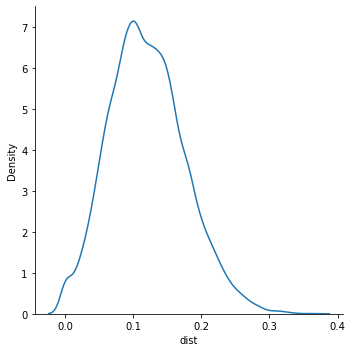

In [54]:
sns.displot(df, x='dist', kind='kde')